In [2]:
import torch

In [3]:
### Select device (GPU) ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

print('Selected device:', device)

Selected device: cuda


In [4]:
import random

### Reading data set ###

with open('../data-sets/Bijbel.txt', 'r', encoding='utf-8') as f:
    text = f.read()

dataset = text

print('Random line:', random.choice(dataset.split('\n')))
print('Size of dataset:', len(dataset.split('\n')), 'lines')

Random line: De Behemoth
Size of dataset: 46680 lines


In [5]:
unique_chars = sorted(set(dataset))

### Character-based tokenization ###

char_to_num = {char: num for num, char in enumerate(unique_chars)}
num_to_char = {num: char for char, num in char_to_num.items()}

vocab_size = len(unique_chars) # Vocabulary size |V|

print(unique_chars)
print('Number of tokens:', vocab_size)

['\n', ' ', '!', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Z', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'Ë', 'Í', 'Ï', 'Ó', 'Ú', 'Ü', 'á', 'ä', 'è', 'é', 'ë', 'í', 'ï', 'ó', 'ú', 'ü']
Number of tokens: 91


In [5]:
### Process data set ###

train_frac = 0.95
seq_length = 40


def build_dataset(data):
    X, Y = [], []
    
    # RNN does not need equally long inputs, but
    # because of batches we still pad with zeros
    context = [0] * seq_length
    
    for ch in data:
        X.append(context)
        ix = char_to_num[ch]
        context = context[1:] + [ix]
        Y.append(context)

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


split = int(train_frac * len(dataset))

Xtr, Ytr = build_dataset(dataset[:split])
Xte, Yte = build_dataset(dataset[split:])

print('Example shape:', Xtr[0].shape, '=>', Ytr[0].shape)
print('Amount of train examples:', len(Xtr))

Example shape: torch.Size([40]) => torch.Size([40])
Amount of train examples: 4112821


In [6]:
import torch.nn as nn

### Create recurrent neural network ###

emb_dim     =  60
hidden_size = 200


class RNN(nn.Module):
    
    def __init__(self, hidden_size, num_layers=1):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.rnn        = nn.RNN(emb_dim, hidden_size, num_layers, batch_first=True)
        self.fc         = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden):    
        embs = self.embeddings(input) # (B x Seq len x emb dim)

        output, hidden = self.rnn(embs, hidden)
        output = self.fc(output)

        if input.dim() == 2:
            output = output.permute(0, 2, 1)
        
        return output, hidden

    def init_hidden(self, batch_size=None):
        if batch_size is None:
            return torch.zeros(self.num_layers, self.hidden_size).to(device)
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)


model = RNN(hidden_size).to(device)

print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 76151


In [7]:
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
from tqdm import trange
import torch.nn.functional as F

### Train network ###

epochs          = 50000
batch_size      =    64
eval_batch_size =  9600

epoch_count       = []
train_loss_values = []
test_loss_values  = []
gradients_norm    = []


for epoch in trange(epochs):
    
    # Sample mini-batch and send to gpu
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)

    hidden = model.init_hidden(batch_size) # Initialize hidden state
    output, _ = model(Xb, hidden)          # Do the forward pass
    loss = criterion(output, Yb)           # Calculate the loss
    optimizer.zero_grad()                  # Reset parameters
    loss.backward()                        # Backpropagation
    optimizer.step()                       # Update parameters

    # Report progression every so often
    if ((epoch + 1) % (epochs / 50) == 0):

        gradients_norm.append(
            torch.tensor(
                [torch.norm(param.grad).item() for param in model.parameters() if param.grad is not None]
            ).norm().item())

        with torch.inference_mode():
        
            # Sample larger train-batch
            ix = torch.randint(0, Xtr.shape[0], (eval_batch_size,))
            Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)
            
            hidden = model.init_hidden(eval_batch_size)
            output, _ = model(Xb, hidden)
            loss = F.cross_entropy(output, Yb)

            # Sample larger test-batch
            ix = torch.randint(0, Xte.shape[0], (eval_batch_size,))
            Xb, Yb = Xte[ix].to(device), Yte[ix].to(device)

            hidden = model.init_hidden(eval_batch_size)
            output, _ = model(Xb, hidden)
            test_loss = F.cross_entropy(output, Yb)
            
            # Log data
            epoch_count.append(epoch)
            train_loss_values.append(loss.item())
            test_loss_values.append(test_loss.item())


# Print final results
print()
print('Final training loss:', round(loss.item(), 3))
print('Final test loss:    ', round(test_loss.item(), 3))

100%|██████████| 50000/50000 [00:54<00:00, 922.12it/s] 


Final training loss: 1.259
Final test loss:     1.381


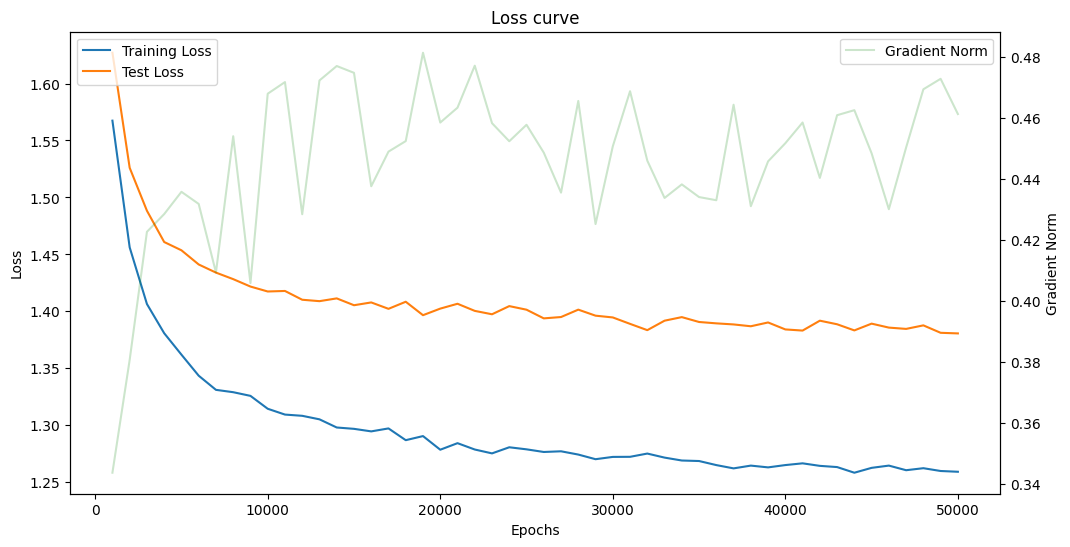

In [9]:
import matplotlib.pyplot as plt

### Visualize loss progression ###

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot training and test loss on the left y-axis
ax1.plot(epoch_count, train_loss_values, label="Training Loss")
ax1.plot(epoch_count, test_loss_values, label="Test Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss curve")

# Plot gradient norm on the right y-axis
ax2 = ax1.twinx()
ax2.plot(epoch_count, gradients_norm, 'g', alpha=0.2, label="Gradient Norm")
ax2.set_ylabel("Gradient Norm")

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [10]:
### Use model ###

@torch.inference_mode()
def evaluate(model, start='\n', length=500):
    hidden = model.init_hidden()
    prime_input = torch.tensor([char_to_num[c] for c in start])

    # Build up hidden state with input text
    for i in range(len(start) - 1):
        _, hidden = model(prime_input[i].unsqueeze(0).to(device), hidden)

    predicted = start

    # Generate new sequence based on hidden state
    input = prime_input[-1].unsqueeze(0)
    for _ in range(length):
        output, hidden = model(input.to(device), hidden)

        probs = F.softmax(output, dim=1)
        ix = torch.multinomial(probs, num_samples=1)[0]

        char = num_to_char[ix.item()]
        predicted += char
        input = ix
    
    return predicted


print(evaluate(model, 'In het begin ', 1000))

In het begin is vandaag bracht heden wat ik gegeven had de eten, de broeve gemaaktareljaar strijdbare wolgen1 aan die naar Juda en kwamen ombeiden verklaren: Maat hij riep hij geven, dat wij allen heeft stuurde van de eerdervcheen en hun gouwen en vóór uw zonen van uw volharen een geboden heeft, zijn lammoom van Syriftig en vanstgaanien in zijn prijft onrein van mond als koning Salomom, zal groep iemand in heel het jaar ? zodat hij het eerste beeft en die bij de meezelf, want zij bevestigd worden, die gesproken had, want ik al zondigering dam als zij niet strijdbin. Al doe mishoogste vraam van de profetes derde vinden hebben, zal over wie de zuster hebt het zó, met haar zijn is hart,
29 en verblijd, en vasmel gesluitte: Een ordenen afzonderen Traf niet van alle koning 14 En wat immers die in erfelijk 10.
14 De onveet, zal van het huis is opgemen.
8 Wie hen in, maar de raadsvoordeklagen: Ik ben mij gelevende zijn vertruikend maken naar twee hoperen
1 Opsten worden. 
2: r 19:k bitterheid